# Analysis of School Openspace with Sentinel-2 RGB mosaics

In [1]:
import os
import sys

import geopandas as gpd
from geopandas.tools import overlay

import shapely.geometry as geometry
from shapely.ops import linemerge, unary_union, polygonize

### _Initialise environment to create instance of Sentinel-Hub client_

In [2]:
# define repo name and get root working directory
repo = 'overpass-api'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\crwil\\Documents\\GitHub\\overpass-api'

In [3]:
# add repo source + notebooks directory to system path
import sys
sys.path.insert(0, os.path.join( root_path, 'src' ) )
sys.path.insert(0, os.path.join( root_path, 'notebooks' ) )

In [4]:
# add repo source + notebooks directory to system path
src_path = os.path.join( os.path.dirname( root_path ), 'sentinelhub' )
sys.path.insert(0, os.path.join( src_path, 'src' ) )

In [5]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'sentinelhub' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\overpass-api\\cfg\\sentinelhub'

In [6]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 's2-mosaic-rgb.yml' )

# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |
                //VERSION=3
                function setup() {
                    return {
                        input: [{
                            bands: ["B04", "B03", "B02"]
                        }],
                        output: {
                            bands: 3
                        }
                    };
                }
                function evaluatePixel(sample) {
                    return [sample.B04, sample.B03, sample.B02];
                }
    inputs:
        - collection: SENTINEL2_L2A
          mosaic:
            order: leastCC   
responses:
    default: TIFF
aoi:
    pathname: <path-to-aoi-file>   
    name: name
    distance: 500



In [7]:
import yaml;
from munch import munchify

# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

In [8]:
# create instance of process api client 
from processapi.client import Client
client = Client( config )

C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\sentinelhub\sh_utils.py:90: SHDeprecationWarning: Parameter base_url is deprecated and will soon be removed. Instead set config.sh_base_url = base_url and provide it with config parameter
  warnings.warn('Parameter base_url is deprecated and will soon be removed. Instead set '


### _Retrieve OSM school amenities intersecting arbitrary bounding box_

In [9]:
# aoi encompassing sussex county
bbox = (50.72222,-0.9575,51.16722,0.04527778)

In [10]:
# create client object
from client import Client
obj = Client()

In [11]:
df_amenity = obj.getWaysInBoundingBox( 'amenity', bbox, value='school', tags=['name','addr:postcode'] )

In [12]:
# compute area in uk national grid coordinates
df_amenity = df_amenity.to_crs( 27700 )
df_amenity[ 'area' ] = df_amenity[ 'geometry' ].area

# sort on area column and revert to geographic coordinates
df_amenity.sort_values( 'area', ascending=False, inplace=True )
df_amenity.reset_index( drop=True, inplace=True )
df_amenity = df_amenity.to_crs( 4326 )
        
df_amenity.head(25)

,id,geometry,name,addr:postcode,area
0,314916357,"POLYGON ((-0.49428 51.15509, -0.49398 51.15495...",Cranleigh School,GU6 8QQ,516860.633414
1,168362398,"POLYGON ((-0.30112 50.84428, -0.30144 50.84428...",Lancing College,BN15 0RW,456238.455368
2,170302233,"POLYGON ((-0.94699 51.02212, -0.94602 51.02224...",Bedales Schools,GU32 2DG,425233.694465
3,227489222,"POLYGON ((-0.74335 50.84216, -0.74296 50.84227...",Westbourne House School,PO20 2BH,233501.424712
4,313763214,"POLYGON ((-0.49297 51.14893, -0.49289 51.14900...",Cranleigh Preparatory School,GU6 8QH,220862.898409
5,164938607,"POLYGON ((-0.66706 50.87637, -0.66710 50.87634...",Great Ballard School,PO18 0LR,206916.243742
6,447262338,"POLYGON ((0.00684 51.03803, 0.00708 51.03803, ...",Cumnor House School,RH17 7HT,194188.001849
7,676324975,"POLYGON ((-0.64715 51.13966, -0.64551 51.13992...",King Edward's School,GU8 5SG,193564.470110
8,26292703,"POLYGON ((-0.77348 50.83002, -0.77410 50.82829...",Chichester High School,PO19 8EB,190627.326042
9,226699636,"POLYGON ((-0.07834 50.80972, -0.08016 50.81018...",Roedean School,BN2 5RQ,186579.341272


### _Demonstrate retrieval of Sentinel-2 cloud-free mosaics collocated with largest school openspace_

In [13]:
from datetime import datetime

# for each month in year
timeframes = []
for year in range( 2018, 2022 ):
    
    timeframes.append( { 'start' : datetime( year, 7, 1, 0, 0, 0 ), 
                            'end' : datetime( year, 8, 31, 23, 59, 59 ) } )    
timeframes

[{'start': datetime.datetime(2018, 7, 1, 0, 0),
  'end': datetime.datetime(2018, 8, 31, 23, 59, 59)},
 {'start': datetime.datetime(2019, 7, 1, 0, 0),
  'end': datetime.datetime(2019, 8, 31, 23, 59, 59)},
 {'start': datetime.datetime(2020, 7, 1, 0, 0),
  'end': datetime.datetime(2020, 8, 31, 23, 59, 59)},
 {'start': datetime.datetime(2021, 7, 1, 0, 0),
  'end': datetime.datetime(2021, 8, 31, 23, 59, 59)}]

In [14]:
# demonstrate analysis on biggest school
big_school = df_amenity.iloc[ 0 ]
big_school[ 'geometry'].bounds

(-0.504572787871974,
 51.145485695121295,
 -0.4886872878625841,
 51.15515489512853)

In [15]:
# sentinel-2 full resolution for visible / nir
resolution = 10

# get utm bbox + 2% buffer distance
bbox = client.getBoundingBox( big_school[ 'geometry'].bounds )
bbox = bbox.buffer( 1 )
print ( bbox, bbox.crs.value )

674006.1264143022,5668408.026158733,676154.6134653877,5670633.7949113995 32630


In [16]:
# get school image dimensions
client.getBoxDimensions( bbox, resolution )

(215, 223)

In [17]:
# get mosaic between timeframe at specified pixel resolution
response = client.getMosaics ( bbox, timeframes, resolution )
response._df

,default,start,end
0,"[[[29, 22, 15], [30, 23, 16], [29, 22, 15], [1...",2018-07-01,2018-08-31 23:59:59
1,"[[[15, 17, 11], [13, 18, 11], [11, 15, 10], [8...",2019-07-01,2019-08-31 23:59:59
2,"[[[34, 24, 18], [33, 24, 18], [25, 21, 15], [1...",2020-07-01,2020-08-31 23:59:59
3,"[[[13, 16, 8], [13, 17, 9], [11, 16, 8], [8, 1...",2021-07-01,2021-08-31 23:59:59


In [18]:
# boost contrast
import numpy as np

factor=3.5/255
response._df[ 'default-vis' ] = response._df[ 'default' ] * factor
response._df[ 'default-vis' ] = response._df.apply( lambda row : np.clip( row['default-vis' ], 0, 255 ), axis = 1 )

### _Retrieve all OSM building features intersecting largest school bounding box_

In [19]:
# use bounding box of school amenity feature
bounds = big_school[ 'geometry' ].bounds
bounds = ( bounds[ 1 ], bounds[ 0 ], bounds[ 3 ], bounds[ 2 ] )

# extract building polygons via overpass
df_building = obj.getWaysInBoundingBox( 'building', bounds, value='school', tags=['name','addr:postcode'] )
df_building

,id,geometry,name,addr:postcode
0,300375433,"POLYGON ((-0.49019 51.14861, -0.49005 51.14858...",Wheeler,None
1,300377874,"POLYGON ((-0.48994 51.14828, -0.48995 51.14825...",Couper,None
2,312669264,"POLYGON ((-0.49027 51.14885, -0.49034 51.14873...",None,None
3,312669265,"POLYGON ((-0.48954 51.14850, -0.48969 51.14825...",Wyatt Hall,None
4,312669266,"POLYGON ((-0.49025 51.14869, -0.49016 51.14884...",Ferrier,None
5,312670858,"POLYGON ((-0.49296 51.15231, -0.49257 51.15243...",Indoor Cricket School,None
6,312670859,"POLYGON ((-0.49263 51.15145, -0.49240 51.15153...",Fives Court,None
7,312670860,"POLYGON ((-0.49391 51.15153, -0.49362 51.15161...",Common Room,None
8,312670863,"POLYGON ((-0.49512 51.15019, -0.49516 51.15023...",Speech Hall,None
9,312672564,"POLYGON ((-0.49474 51.15027, -0.49463 51.15031...",Connaught / South House,None


In [20]:
# compute overlay difference
df_school = gpd.GeoDataFrame( big_school ).transpose()
df_school = df_school.set_crs ( 4326 )

df_openspace = overlay( df_school, 
                        df_building, 
                        how='difference' )

df_openspace = df_openspace.to_crs( int ( bbox.crs.value ) )

### _Visualise openspace polygon superimposed on OpenStreetMap and Sentinel-2 mosaic images_

C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


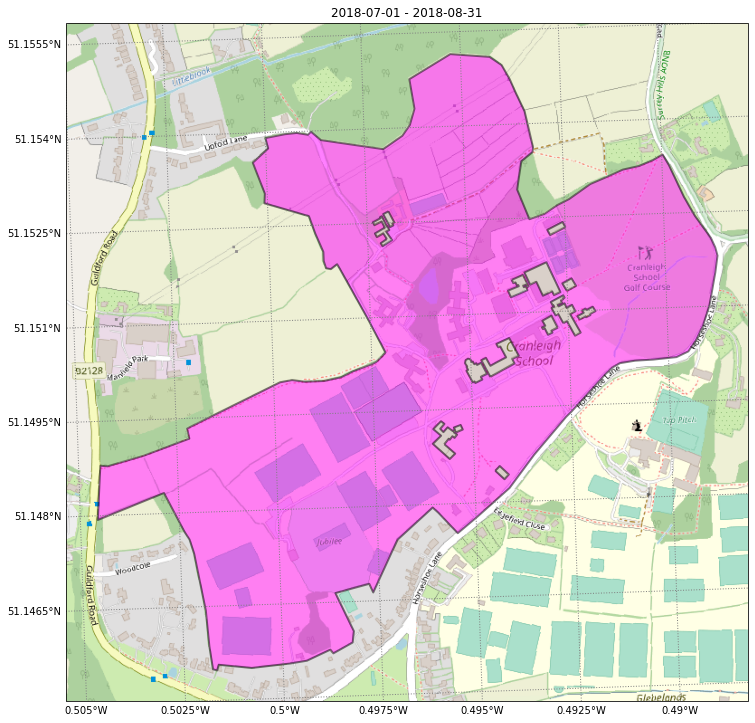

In [21]:
from geopandas import GeoSeries

# polygons to add to image plot
annotation = { 'features' : df_openspace[ 'geometry'],
               'facecolor' : 'magenta',
               'edgecolor' : 'black',
               'linewidth' : 2,
               'alpha' : 0.5
             }

# plot images
response.plotImages(    osm_zoom=16,
                        gridlines=True,
                        annotation=annotation,
                        interpolation='bicubic',
                        scale=(10,10) )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


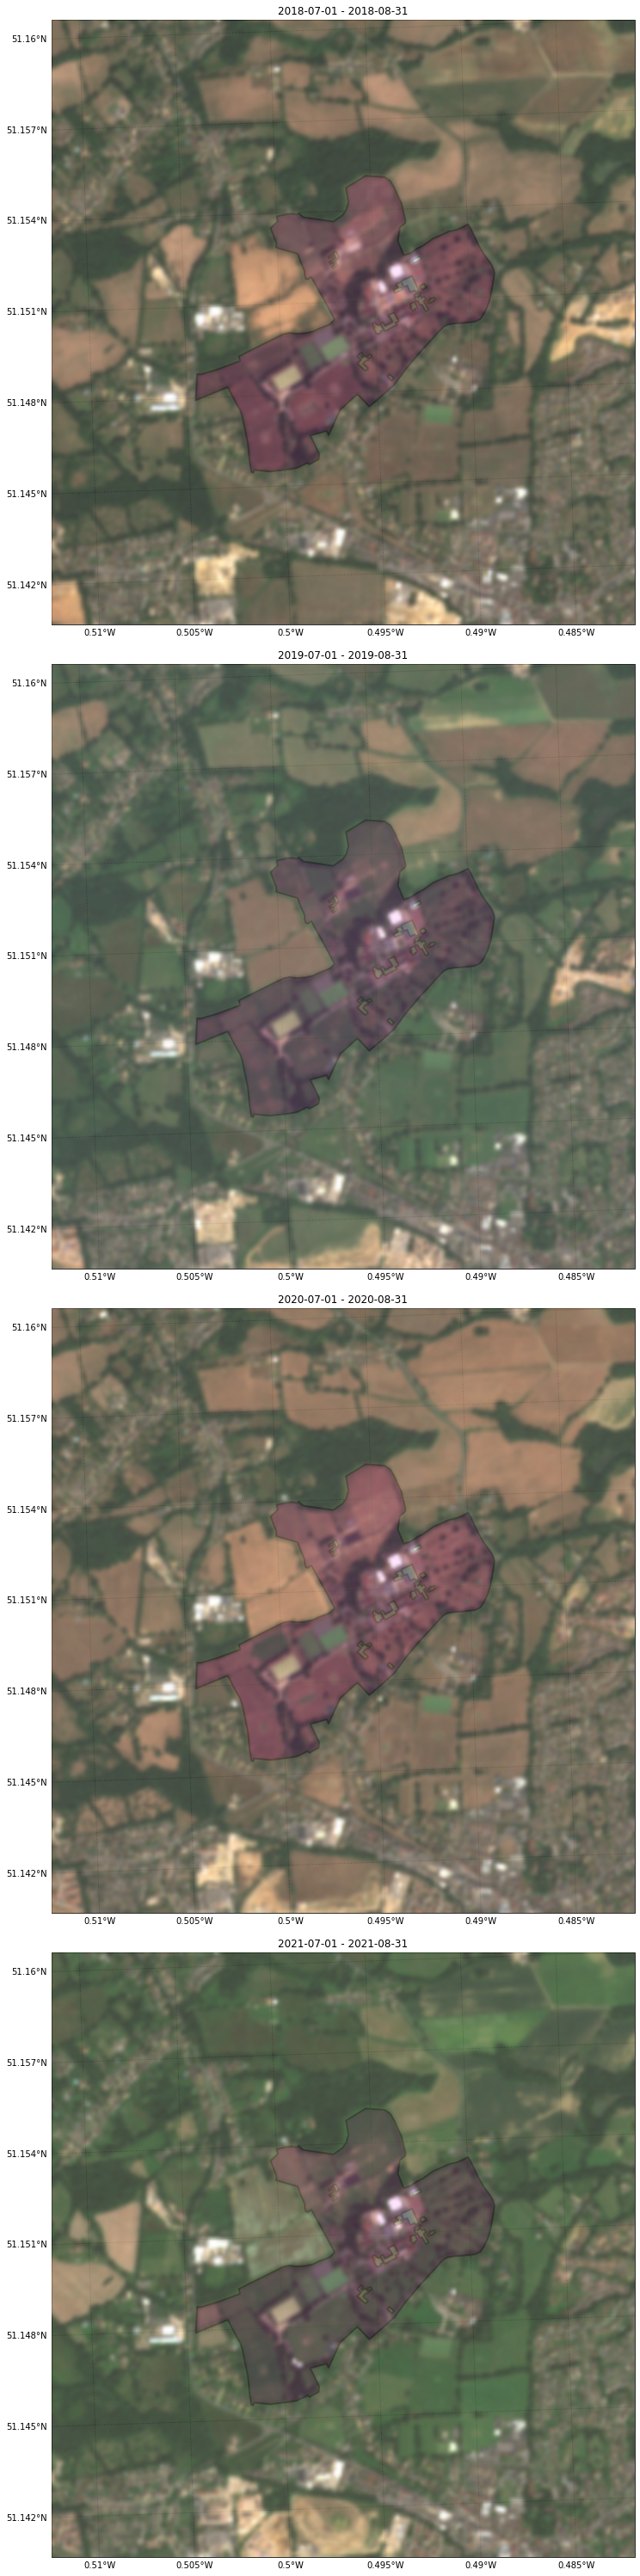

In [22]:
# plot images
response.plotImages(    name='default-vis',
                        alpha={ 'data' : 0.8 },
                        gridlines=True,
                        annotation=annotation,
                        interpolation='bicubic',
                        scale=(10,10) )

### _Use RasterIO to clip Sentinel-2 mosaic by openspace polygon_

In [23]:
import rasterio
from rasterio.crs import CRS
from affine import Affine

raster = response._df[ 'default-vis' ].iloc[ 0 ].transpose( 2, 0, 1 )
print ( raster.shape )

memfile = rasterio.io.MemoryFile()
ds = memfile.open(  driver='GTiff',
                    height=raster.shape[1],
                    width=raster.shape[2],
                    count=3,
                    dtype=raster.dtype,
                    crs=CRS.from_epsg( int ( response._bbox.crs.value ) ),
                    transform=Affine.from_gdal(*response._transform)
                )

ds.write(raster)
print(ds.profile)

(3, 223, 215)
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 215, 'height': 223, 'count': 3, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 674006.1264143022,
       0.0, -10.0, 5670633.7949113995), 'tiled': False, 'interleave': 'pixel'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


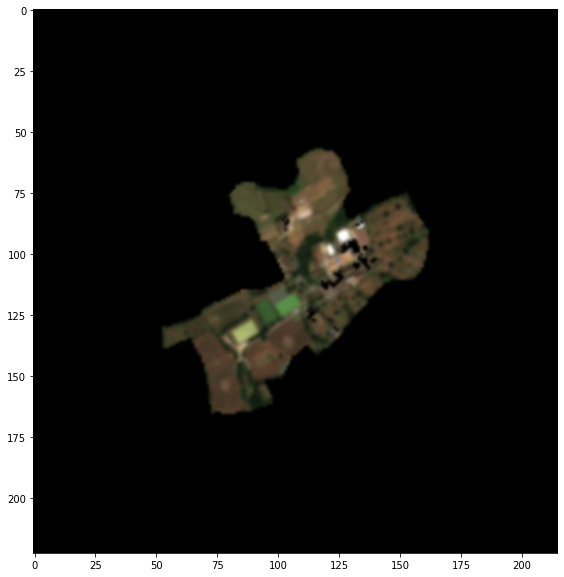

In [24]:
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.mask import mask

fig, ax = plt.subplots(figsize=(10, 10))
data = mask( ds, df_openspace[ 'geometry' ], nodata=0)
ax.imshow( data[ 0 ].transpose( 1, 2, 0 ), interpolation='bicubic' )